In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.linear_model import ElasticNet

import pickle

# Dataset

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 7)
df = pd.read_csv('data.csv').drop(columns=['Ticket Price Avg. USD', 'Avg. Tickets Sold', 'Currency'])

## Data Cleaning

In [3]:
# Convert 'Event Date' to datetime if it's not already
df['Event Date'] = pd.to_datetime(df['Event Date'], errors='coerce')

# Sort the DataFrame by 'Event Date' (ascending order)
df = df.sort_values('Event Date')

# Determine the split index (80% for training, 20% for testing)
split_index = int(0.8 * len(df))

# Split the dataset
train = df.iloc[:split_index]
test = df.iloc[split_index:]

In [4]:
def fill_missing_values(df, column_name):
    # Clean the column by removing unwanted characters
    df[column_name] = df[column_name].replace({'%': '', ',': ''}, regex=True)
    
    # Convert the column to numeric, coercing errors to NaN
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
    
    # Fill missing values with the mean of the respective 'Venue', ignoring NaN values
    df[column_name] = df.groupby('Venue')[column_name].transform(lambda x: x.fillna(x.mean()))
    
    # If still missing, fill with the global mean
    global_mean = df[column_name].mean()
    df[column_name] = df[column_name].fillna(global_mean)
    
    return df

def preprocess_data(df):
    # Step 1: Convert 'Event Date' to numerical features
    df['Event Date'] = pd.to_datetime(df['Event Date'])
    df['year'] = df['Event Date'].dt.year
    df['month'] = df['Event Date'].dt.month
    df['day'] = df['Event Date'].dt.day
    df['weekday'] = df['Event Date'].dt.weekday
    df['hour'] = df['Event Date'].dt.hour  # Assuming time is included; otherwise, set to 0

    # Drop the 'Event Date' column if no longer needed
    df.drop(columns=['Event Date'], inplace=True)

    # Step 2: Convert currency columns to float
    currency_columns = ['Avg. Gross USD', 'Ticket Price Min USD', 'Ticket Price Max USD']
    for col in currency_columns:
        df[col] = df[col].replace({'\$': '', ',': ''}, regex=True).astype(float)

    # Step 3: Handle missing values in 'Avg. Capacity Sold' using the helper function
    df = fill_missing_values(df, 'Avg. Capacity Sold')
    
    # Step 4: Handle missing values for specific categorical columns
    categorical_columns = ['Support', 'Market', 'Genre', 'Promoter', 'Company Type', 'Venue', 'State']
    for col in categorical_columns:
        df[col] = df[col].fillna('None')
    
    # Step 5: Handle missing values in 'Avg. Event Capacity' using the helper function
    df = fill_missing_values(df, 'Avg. Event Capacity')
    
    return df


In [5]:
preprocess_data(train)
preprocess_data(test)

C:\Users\sarah\AppData\Local\Temp\ipykernel_27796\129640061.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Event Date'] = pd.to_datetime(df['Event Date'])
C:\Users\sarah\AppData\Local\Temp\ipykernel_27796\129640061.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['Event Date'].dt.year
C:\Users\sarah\AppData\Local\Temp\ipykernel_27796\129640061.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

,Number of Shows,Headliner,Support,Venue,City,State,Country,Market,Company Type,Promoter,Genre,Avg. Gross USD,Avg. Event Capacity,Avg. Capacity Sold,Ticket Price Min USD,Ticket Price Max USD,year,month,day,weekday,hour
141031,1,Brothers Osborne,The Wild Feathers,Alabama Theatre,Birmingham,Alabama,United States,Birmingham (Anniston and Tuscaloosa),Auditorium / Theatre,Red Mountain Entertainment,Country,65835.6,2164.0,66.0,27.5,47.5,2019,2,6,2,0
141044,1,Greg Brown,None,The Hamilton Live,Washington,District of Columbia,United States,"Washington, D.C. (Hagerstown)",Club,(In-House Promotion),Folk,8465.0,520.0,44.0,25.0,50.0,2019,2,6,2,0
141029,1,"Mozes And The Firstborn, The Parrots",Harper's Jar,7th St Entry,Minneapolis,Minnesota,United States,Minneapolis-St. Paul,Club,First Avenue Productions,Pop / Rock,191.5,240.0,7.0,9.5,11.5,2019,2,6,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,1,Bruce Springsteen & The E Street Band,None,Oriole Park at Camden Yards,Baltimore,Maryland,United States,Baltimore,Stadium,Live Nation,Pop / Rock,6556587.0,39646.0,100.0,49.5,299.5,2024,9,13,4,0
1,1,Creed,"3 Doors Down, Finger Eleven",The Cynthia Woods Mitchell Pavilion,The Woodlands,Texas,United States,Houston,Amphitheatre,Live Nation,Pop / Rock,1374174.0,16308.0,100.0,39.5,225.0,2024,9,14,5,0
0,1,Creed,"3 Doors Down, Finger Eleven",Coastal Credit Union Music Park at Walnut Creek,Raleigh,North Carolina,United States,Raleigh-Durham (Fayetteville),Amphitheatre,Live Nation,Pop / Rock,1228939.0,20295.0,100.0,39.5,225.0,2024,9,18,2,0


## Exploratory Data Analysis

In [68]:
train.columns

Index(['Number of Shows', 'Headliner', 'Support', 'Venue', 'City', 'State',
       'Country', 'Market', 'Company Type', 'Promoter', 'Genre',
       'Avg. Gross USD', 'Avg. Event Capacity', 'Avg. Capacity Sold',
       'Ticket Price Min USD', 'Ticket Price Max USD', 'year', 'month', 'day',
       'weekday', 'hour'],
      dtype='object')

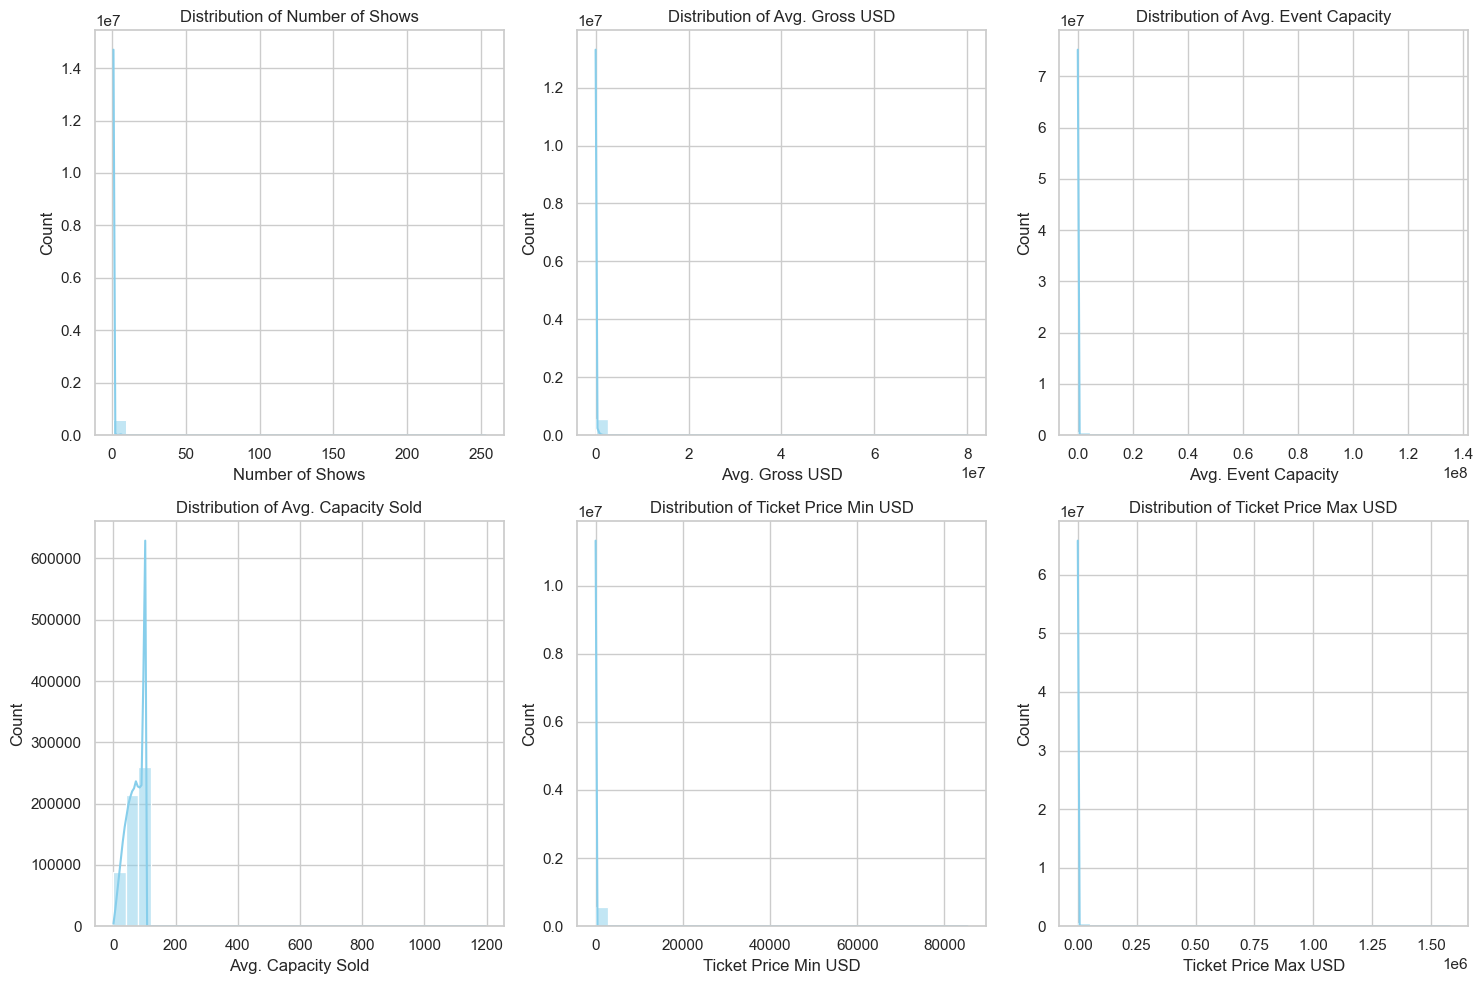

In [69]:
# Set the style
sns.set(style="whitegrid")

# 1. Distribution of Numerical Columns
numerical_cols = ['Number of Shows', 'Avg. Gross USD', 'Avg. Event Capacity', 
                  'Avg. Capacity Sold', 'Ticket Price Min USD', 'Ticket Price Max USD']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(train[col], kde=True, color='skyblue', bins=30)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
plt.show()

C:\Users\sarah\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


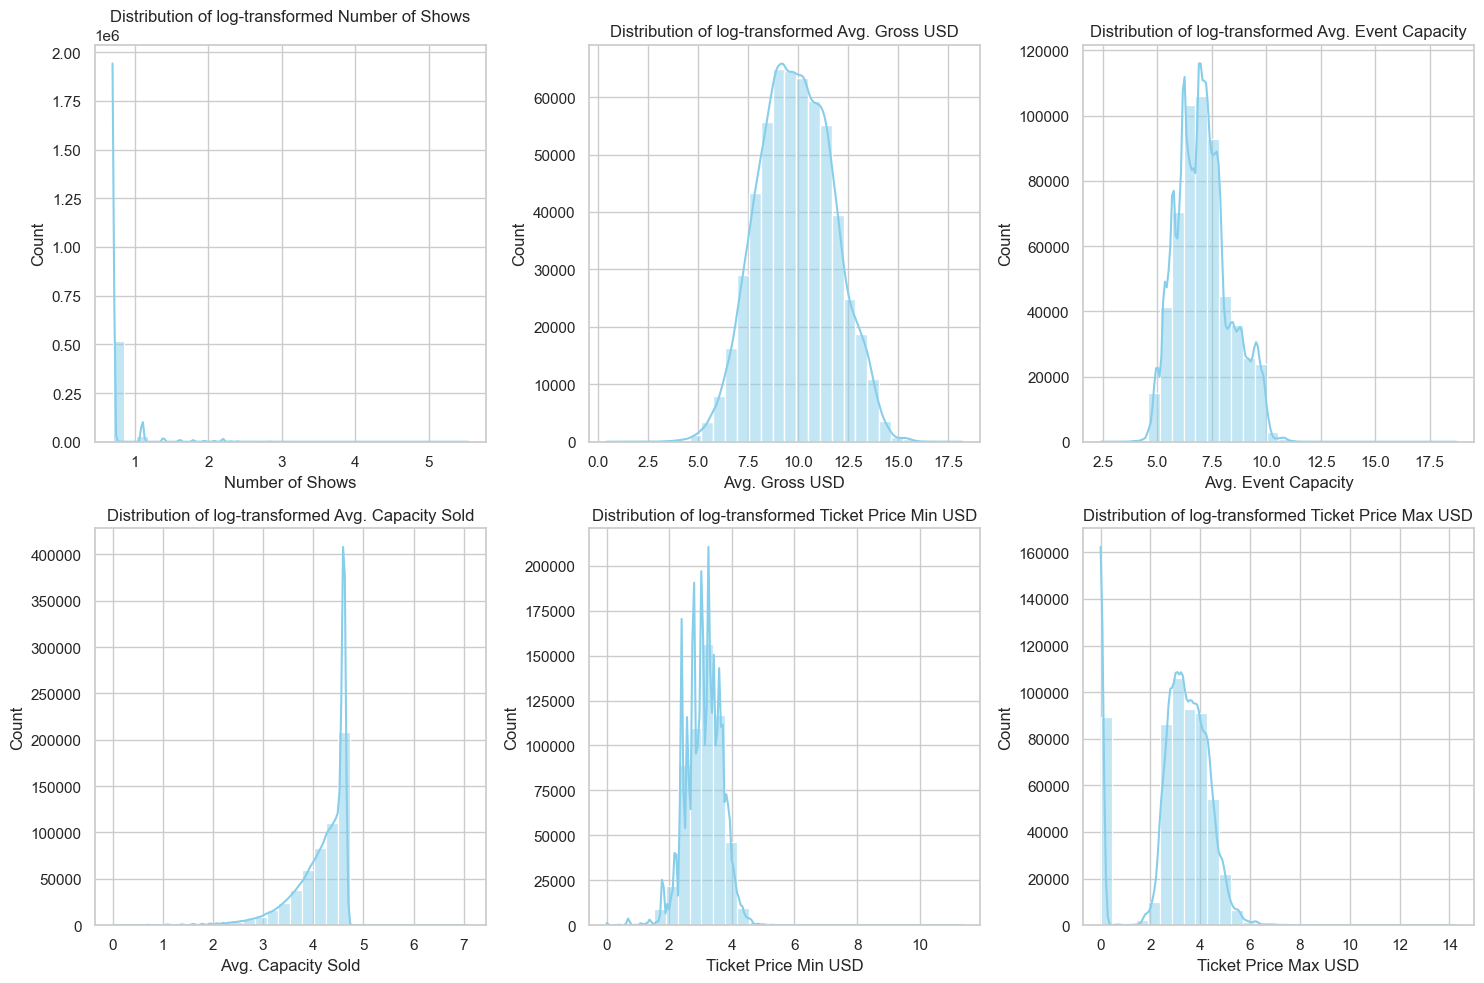

In [70]:
# 2. Distribution of Numerical Columns (Logged)

# List of numerical columns to transform
numerical_cols = ['Number of Shows', 'Avg. Gross USD', 'Avg. Event Capacity', 
                  'Avg. Capacity Sold', 'Ticket Price Min USD', 'Ticket Price Max USD']

# Apply log transformation, adding a small constant to avoid log(0)
train_log = train.copy()  # Make a copy of the original data
test_log = test.copy()  # Make a copy of the original data

for col in numerical_cols:
    # Apply log transformation only to positive values (check for zeros or negatives)
    train_log[col] = np.log1p(train_log[col])  # log1p handles log(x + 1) to avoid issues with zero
    test_log[col] = np.log1p(test_log[col])  # log1p handles log(x + 1) to avoid issues with zero

# Plot the distributions of the log-transformed variables
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(train_log[col], kde=True, color='skyblue', bins=30)
    plt.title(f'Distribution of log-transformed {col}')
    plt.tight_layout()
plt.show()


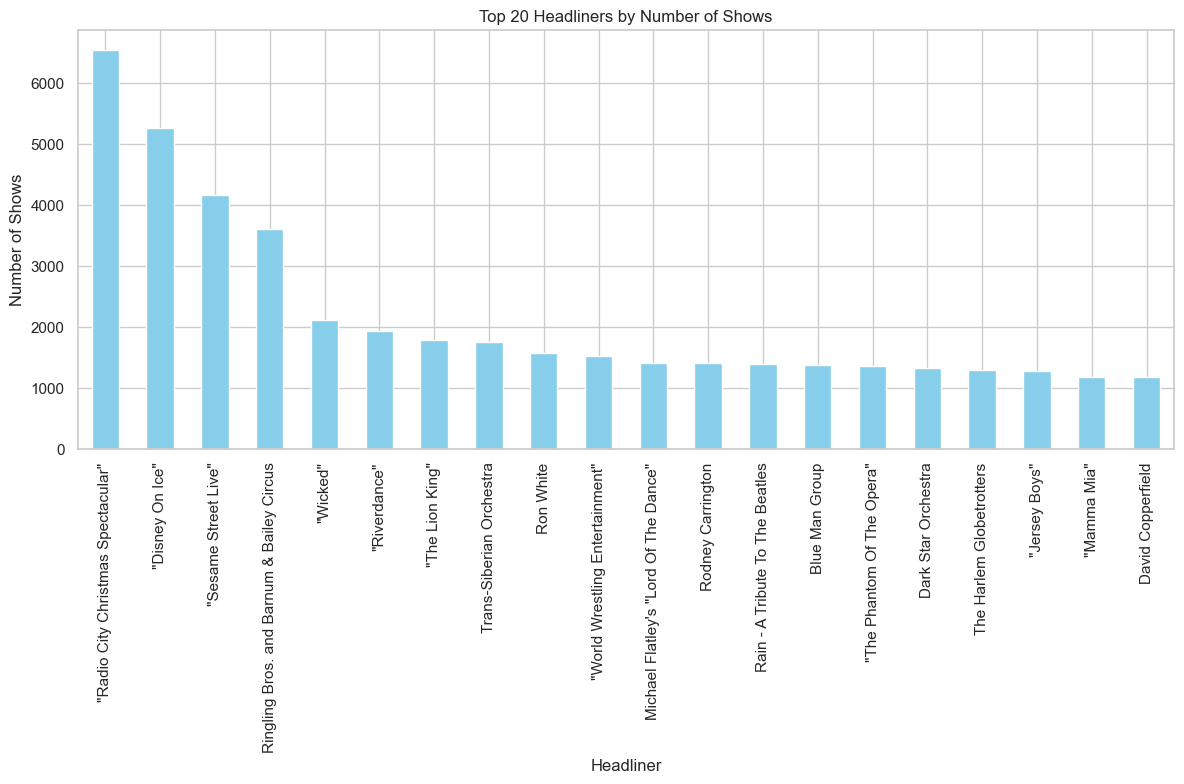

In [71]:
# 3. Bar Chart of Headliner Frequency
# Get the top 20 headliners by the number of shows
top_20_headliners = train.groupby('Headliner')['Number of Shows'].sum().sort_values(ascending=False).head(20)

# Plot the data
plt.figure(figsize=(12, 8))
top_20_headliners.plot(kind='bar', color='skyblue')
plt.title('Top 20 Headliners by Number of Shows')
plt.xlabel('Headliner')
plt.ylabel('Number of Shows')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

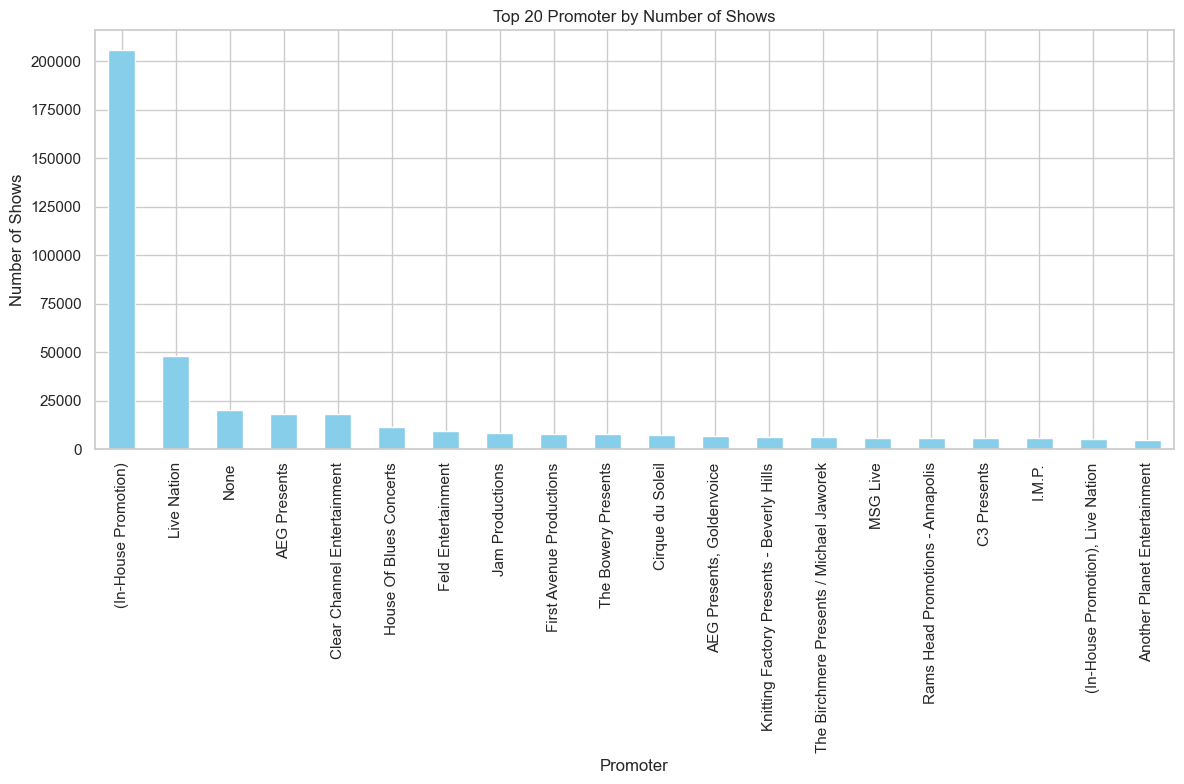

In [72]:
# 4. Bar Chart of Promoter Frequency
# Get the top 20 promoter by the number of shows
top_20_promoters = train.groupby('Promoter')['Number of Shows'].sum().sort_values(ascending=False).head(20)

# Plot the data
plt.figure(figsize=(12, 8))
top_20_promoters.plot(kind='bar', color='skyblue')
plt.title('Top 20 Promoter by Number of Shows')
plt.xlabel('Promoter')
plt.ylabel('Number of Shows')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

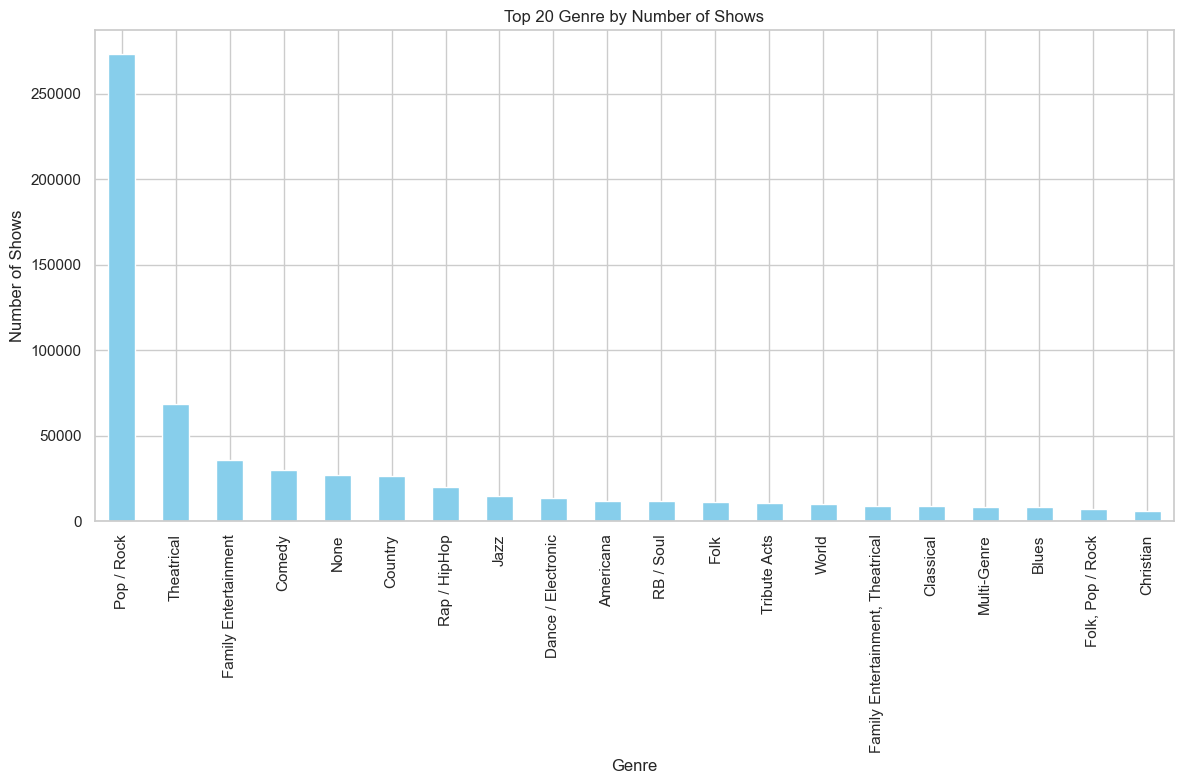

In [73]:
# 5. Bar Chart of Genre Frequency
# Get the top 20 genres by the number of shows
top_20_genres = train.groupby('Genre')['Number of Shows'].sum().sort_values(ascending=False).head(20)

# Plot the data
plt.figure(figsize=(12, 8))
top_20_genres.plot(kind='bar', color='skyblue')
plt.title('Top 20 Genre by Number of Shows')
plt.xlabel('Genre')
plt.ylabel('Number of Shows')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

C:\Users\sarah\AppData\Local\Temp\ipykernel_27796\1240637594.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train, x='month', y='Avg. Gross USD', ci=None)


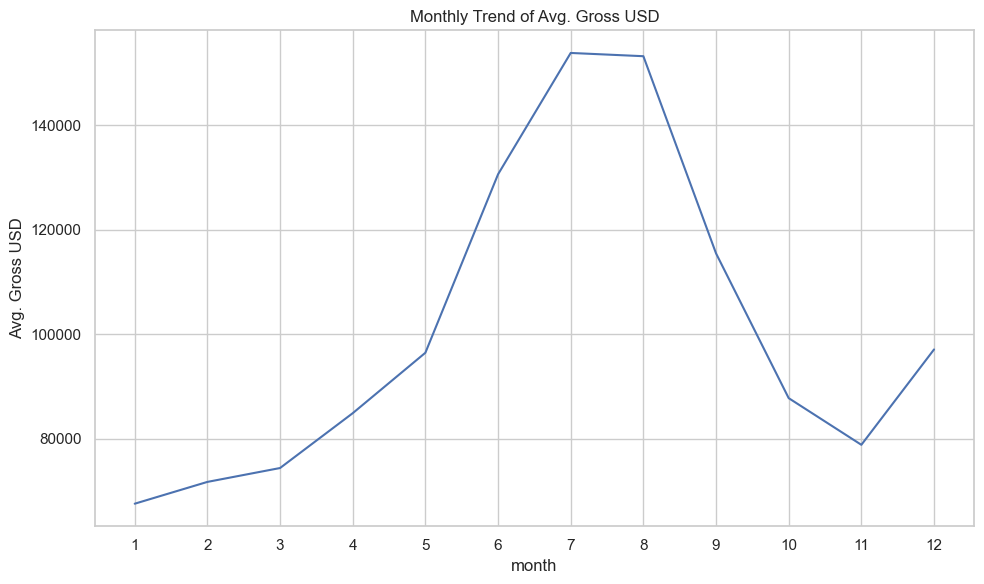

In [74]:
# 6. Time-based Analysis (Monthly Trends for Avg. Gross USD)
plt.figure(figsize=(10, 6))
sns.lineplot(data=train, x='month', y='Avg. Gross USD', ci=None)
plt.title('Monthly Trend of Avg. Gross USD')
plt.xticks(np.arange(1, 13, 1))
plt.tight_layout()
plt.show()

# Predictive Task

## Baseline Model

In [9]:
X_train_num

,Number of Shows,Avg. Gross USD,Avg. Event Capacity,Avg. Capacity Sold,Ticket Price Min USD,Ticket Price Max USD,year,month,day,weekday,hour
704977,1,19854.0,1650,66.0,18.0,18.0,1999,1,1,4,0
704965,2,1897.0,271,100.0,7.0,7.0,1999,1,1,4,0
704966,1,2645.0,300,88.0,10.0,10.0,1999,1,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...
141046,1,310246.0,5996,68.0,39.5,99.5,2019,2,6,2,0
141012,1,45010.0,1248,84.0,29.0,59.0,2019,2,6,2,0
141040,1,2620.0,200,36.0,25.0,40.0,2019,2,6,2,0


In [15]:
# Select numerical columns from the train and test datasets (excluding the target variable)
X_train_num = train.select_dtypes(include=['number']).drop(columns=['Avg. Gross USD'])
X_test_num = test.select_dtypes(include=['number']).drop(columns=['Avg. Gross USD'])

# Drop rows with missing values in X_train_num and X_test_num
X_train_num_clean = X_train_num.dropna()
X_test_num_clean = X_test_num.dropna()

# Assuming 'Avg. Gross USD' is the target variable
y_train = train['Avg. Gross USD']
y_test = test['Avg. Gross USD']

# Ensure y_train and y_test align with the remaining rows after dropping
y_train_clean = y_train[X_train_num_clean.index]
y_test_clean = y_test[X_test_num_clean.index]

# Instantiate and fit the Linear Regression model
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train_num_clean, y_train_clean)

# Make predictions
lin_reg_preds = lin_reg_model.predict(X_test_num_clean)

# Evaluate performance
lin_reg_rmse = np.sqrt(mean_squared_error(y_test_clean, lin_reg_preds))
lin_reg_mae = mean_absolute_error(y_test_clean, lin_reg_preds)

# Print performance
print("Linear Regression Model Performance on Test Set (Numerical Columns Only):")
print(f"RMSE: {lin_reg_rmse:.4f}")
print(f"MAE: {lin_reg_mae:.4f}")

Linear Regression Model Performance on Test Set (Numerical Columns Only):
RMSE: 86206148.0387
MAE: 426823.1545


# Model (Logged Numerical Columns + CatBoost + LightGBM Stacked)

In [51]:
# Define features and target
X = train_log.drop(columns=['Avg. Gross USD'])
y = train_log['Avg. Gross USD']

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = test_log.drop(columns=['Avg. Gross USD'])
y_test = test_log['Avg. Gross USD']

# Define your categorical columns
categorical_cols = ['Headliner', 'Support', 'Venue', 'City', 'State', 'Country', 
                    'Market', 'Company Type', 'Promoter', 'Genre', 'month', 'weekday']

# Convert them to 'category' dtype (this is required for LightGBM; optional but good for CatBoost)
# Convert the categorical columns to 'category' dtype for both training and test data
for col in categorical_cols:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

In [21]:
# Train CatBoost model with default hyperparameters
catboost_model = CatBoostRegressor(
    cat_features=categorical_cols,
    iterations=1000,  # You can increase the number of iterations if needed
    learning_rate=0.1,  # Default learning rate
    depth=6,  # Default depth
    verbose=200  # Display progress every 200 iterations
)

# Fit the model to the training data
catboost_model.fit(X_train, y_train)

# Predict on the validation set
cat_y_val_pred = catboost_model.predict(X_val)

# Evaluate
cat_rmse = mean_squared_error(y_val, cat_y_val_pred, squared=False)
cat_r2 = r2_score(y_val, cat_y_val_pred)
cat_mae = mean_absolute_error(y_val, cat_y_val_pred)

# Print results
print("CatBoost Model Performance:")
print(f"RMSE: {cat_rmse:.4f}")
print(f"R2 Score: {cat_r2:.4f}")
print(f"MAE: {cat_mae:.4f}")

0:	learn: 1.7009641	total: 721ms	remaining: 12m
200:	learn: 0.1747434	total: 1m 35s	remaining: 6m 20s
400:	learn: 0.1646522	total: 3m 22s	remaining: 5m 2s
600:	learn: 0.1593295	total: 5m 5s	remaining: 3m 22s
800:	learn: 0.1558620	total: 6m 49s	remaining: 1m 41s
999:	learn: 0.1533854	total: 8m 32s	remaining: 0us
CatBoost Model Performance:
RMSE: 0.1610
R2 Score: 0.9926
MAE: 0.0868


C:\Users\sarah\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [26]:
# Ensure that categorical columns in both X_train and X_val have the same categories
for col in categorical_cols:
    # Set categorical dtype in both train and validation datasets
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')

    # Ensure that both X_train and X_val use the same categories (this is crucial for LightGBM)
    X_val[col] = X_val[col].cat.set_categories(X_train[col].cat.categories)

In [27]:
# Train LightGBM model with default hyperparameters
lgb_model = LGBMRegressor(
    objective='regression',
    metric='rmse',
    max_depth=6,  # Reduced from 8 to limit tree depth and prevent overfitting
    num_leaves=31,  # Keeping this moderate to prevent too many leaves
    learning_rate=0.01,  # Lower learning rate for more stable training
    min_child_samples=50,  # Increased to prevent overfitting in small leaf nodes
    lambda_l1=0.1,  # Reduced L1 regularization to avoid too much sparsity
    lambda_l2=0.5,  # Increased L2 regularization to penalize large coefficients
    feature_fraction=0.7,  # Reduced slightly to increase model robustness
    bagging_fraction=0.8,  # Keep bagging fraction as is
    bagging_freq=5,  # Retain regular bagging frequency
    n_estimators=1000,  # Keep the number of estimators as before
    random_state=42,
    verbose=-1,  # Suppress output (set to 1 if you want training logs)
)

# Fit the model to the training data
lgb_model.fit(X_train, y_train, categorical_feature=categorical_cols)

# Predict on the validation set
lgb_y_val_pred = lgb_model.predict(X_val)

# Evaluate
lgb_rmse = mean_squared_error(y_val, lgb_y_val_pred, squared=False)
lgb_r2 = r2_score(y_val, lgb_y_val_pred)
lgb_mae = mean_absolute_error(y_val, lgb_y_val_pred)

# Print results
print("LightGBM Model Performance:")
print(f"RMSE: {lgb_rmse:.4f}")
print(f"R2 Score: {lgb_r2:.4f}")
print(f"MAE: {lgb_mae:.4f}")

LightGBM Model Performance:
RMSE: 0.1754
R2 Score: 0.9912
MAE: 0.1021


C:\Users\sarah\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [65]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Convert categorical columns to category dtype if needed
for col in categorical_cols:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')

# Get base model predictions for training Linear Regression (on training data!)
catboost_train_preds = catboost_model.predict(X_train)
lgb_train_preds = lgb_model.predict(X_train)

# Stack predictions (CatBoost and LightGBM) for the meta-model training
stacked_X_meta_train = np.column_stack((catboost_train_preds, lgb_train_preds))

# Train Linear Regression meta-model
meta_model = LinearRegression()
meta_model.fit(stacked_X_meta_train, y_train)

# Get base model predictions on validation data for final ensemble
catboost_val_preds = catboost_model.predict(X_val)
lgb_val_preds = lgb_model.predict(X_val)

# Stack predictions for meta-model prediction
stacked_X_meta_val = np.column_stack((catboost_val_preds, lgb_val_preds))

# Final predictions from the ensemble meta-model (Linear Regression)
final_preds = meta_model.predict(stacked_X_meta_val)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_val, final_preds))
r2 = r2_score(y_val, final_preds)
mae = mean_absolute_error(y_val, final_preds)

# Print performance
print("Stacked Ensemble Model Performance (Linear Regression):")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")


Stacked Ensemble Model Performance (Linear Regression):
RMSE: 0.1602
R2 Score: 0.9926
MAE: 0.0858


In [66]:
# Get base model predictions on the test set
catboost_test_preds = catboost_model.predict(X_test)
lgb_test_preds = lgb_model.predict(X_test)

# Stack predictions for the meta-model
stacked_X_meta_test = np.column_stack((catboost_test_preds, lgb_test_preds))

# Final predictions from the stacked model (ElasticNet meta-model)
final_test_preds = meta_model.predict(stacked_X_meta_test)

final_test_preds_original = np.expm1(final_test_preds)
y_test_original = np.expm1(y_test)

# Evaluate performance on the test set
test_rmse = np.sqrt(mean_squared_error(y_test_original, final_test_preds_original))
test_r2 = r2_score(y_test_original, final_test_preds_original)
test_mae = mean_absolute_error(y_test_original, final_test_preds_original)

# Print test set performance
print("Stacked Ensemble Model Performance on Test Set:")
print(f"RMSE: {test_rmse:.4f}")
print(f"R2 Score: {test_r2:.4f}")
print(f"MAE: {test_mae:.4f}")

Stacked Ensemble Model Performance on Test Set:
RMSE: 258696.2451
R2 Score: 0.8395
MAE: 43432.3238


# Result

In [75]:
# Save the trained model to a file
with open("meta_model.pkl", "wb") as f:
    pickle.dump(meta_model, f)

C:\Users\sarah\AppData\Local\Temp\ipykernel_27796\1095775824.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  meta_model_result['Actual'].fillna(meta_model_result['Actual'].mean(), inplace=True)
C:\Users\sarah\AppData\Local\Temp\ipykernel_27796\1095775824.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

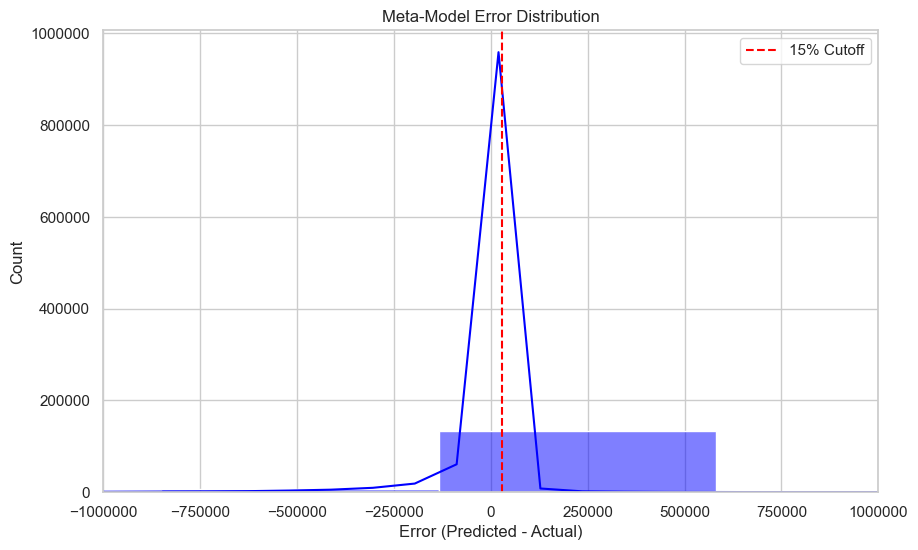

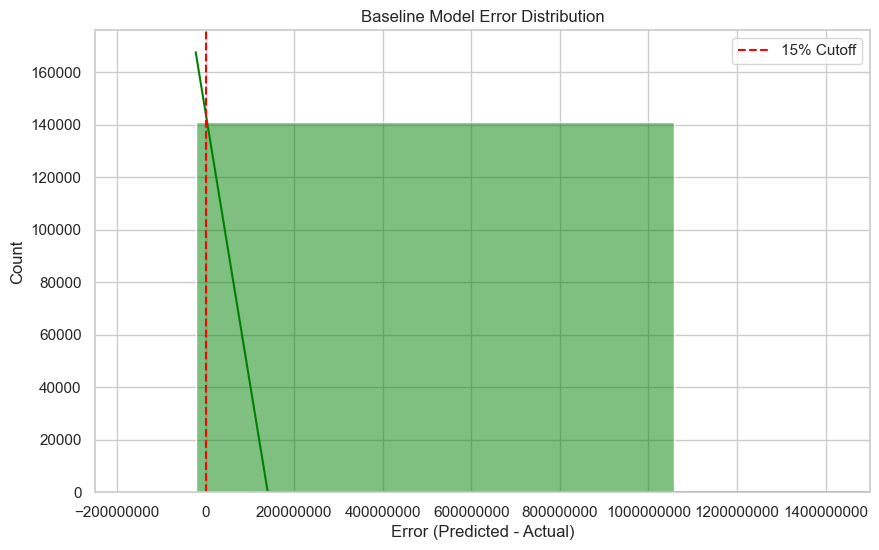

In [119]:
# Meta-model predictions and baseline predictions
meta_model_result = pd.DataFrame({'Actual': y_test_clean, 'Predicted': final_test_preds_original})
baseline_result = pd.DataFrame({'Actual': y_test_clean, 'Predicted': lin_reg_preds})

# Fill missing values in 'Actual' with the mean (if any) for both meta-model and baseline
meta_model_result['Actual'].fillna(meta_model_result['Actual'].mean(), inplace=True)
baseline_result['Actual'].fillna(baseline_result['Actual'].mean(), inplace=True)

# Calculate errors for both models
meta_model_result['Error'] = meta_model_result['Predicted'] - meta_model_result['Actual']
baseline_result['Error'] = baseline_result['Predicted'] - baseline_result['Actual']

# Calculate the 15% error threshold for both models
meta_model_threshold = 0.15 * meta_model_result['Actual']
baseline_threshold = 0.15 * baseline_result['Actual']

# Plot the histogram for the meta-model with counts
plt.figure(figsize=(10, 6))
sns.histplot(meta_model_result['Error'], kde=True, color='blue', bins=30, stat="count")
plt.axvline(x=meta_model_threshold.mean(), color='red', linestyle='--', label='15% Cutoff')  # Red line for 15% cutoff
plt.title('Meta-Model Error Distribution')
plt.xlabel('Error (Predicted - Actual)')
plt.ylabel('Count')
plt.xlim(-1000000, 1000000)  # Set x-axis limits for better visibility
plt.legend()
plt.grid(True)

# Set x and y axis to plain formatting (no scientific notation)
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')

plt.show()

# Plot the histogram for the baseline model with counts
plt.figure(figsize=(10, 6))
sns.histplot(baseline_result['Error'], kde=True, color='green', bins=30, stat="count")
plt.axvline(x=baseline_threshold.mean(), color='red', linestyle='--', label='15% Cutoff')  # Red line for 15% cutoff
plt.title('Baseline Model Error Distribution')
plt.xlabel('Error (Predicted - Actual)')
plt.ylabel('Count')
plt.xlim(-250000000, 1500000000)  # Set x-axis limits for better visibility
plt.legend()
plt.grid(True)

# Set x and y axis to plain formatting (no scientific notation)
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')

plt.show()

In [110]:
# Find instances where the absolute error exceeds 15% of the actual value for both models
meta_model_large_error_instances = meta_model_result[np.abs(meta_model_result['Error']) > meta_model_threshold]
baseline_large_error_instances = baseline_result[np.abs(baseline_result['Error']) > baseline_threshold]

# Calculate accuracy for both models (percentage of predictions within 15% of the actual value)
meta_model_accuracy = 1 - len(meta_model_large_error_instances) / len(meta_model_result)
baseline_accuracy = 1 - len(baseline_large_error_instances) / len(baseline_result)

# Print the accuracies
print(f"Meta-Model Accuracy (within 15% of actual value): {meta_model_accuracy * 100:.2f}%")
print(f"Baseline Model Accuracy (within 15% of actual value): {baseline_accuracy * 100:.2f}%")

# Optionally, view the rows with large errors for both models
print("Rows with large errors for Meta-Model:")
print(meta_model_large_error_instances)

print("Rows with large errors for Baseline Model:")
print(baseline_large_error_instances)

# Compare both models' performances
if meta_model_accuracy > baseline_accuracy:
    print("The meta-model outperforms the baseline model.")
else:
    print("The baseline model outperforms the meta-model.")

Meta-Model Accuracy (within 15% of actual value): 71.06%
Baseline Model Accuracy (within 15% of actual value): 5.57%
Rows with large errors for Meta-Model:
            Actual     Predicted         Error
141031    65835.60  5.351877e+04 -1.231683e+04
141019   473767.67  3.511567e+05 -1.226109e+05
140899    27985.00  2.202295e+04 -5.962051e+03
...            ...           ...           ...
4       9676590.00  6.920861e+06 -2.755729e+06
2       6556587.00  4.929182e+06 -1.627405e+06
1       1374174.00  1.049478e+06 -3.246962e+05

[40806 rows x 3 columns]
Rows with large errors for Baseline Model:
           Actual      Predicted         Error
141031    65835.6   82836.095589  1.700050e+04
141044     8465.0   35302.472404  2.683747e+04
141029      191.5  -45972.189123 -4.616369e+04
...           ...            ...           ...
2       6556587.0  200558.714396 -6.356028e+06
1       1374174.0  201419.583582 -1.172754e+06
0       1228939.0  193333.841480 -1.035605e+06

[133142 rows x 3 colum

In [120]:
# Save the results to CSV files
meta_model_result.to_csv('meta_model_results.csv', index=False)
baseline_result.to_csv('baseline_model_results.csv', index=False)